# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.25$, $\alpha=2.25$) (Alpha upper edge)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2.25

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

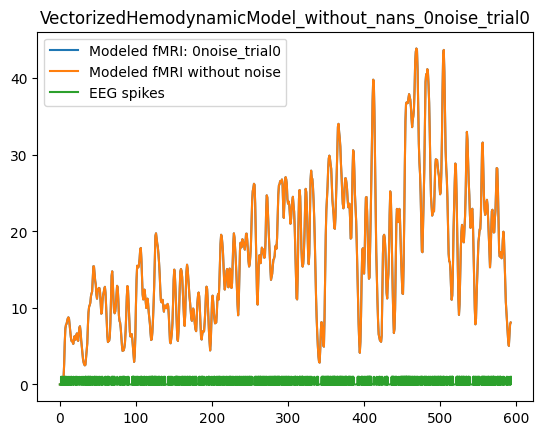

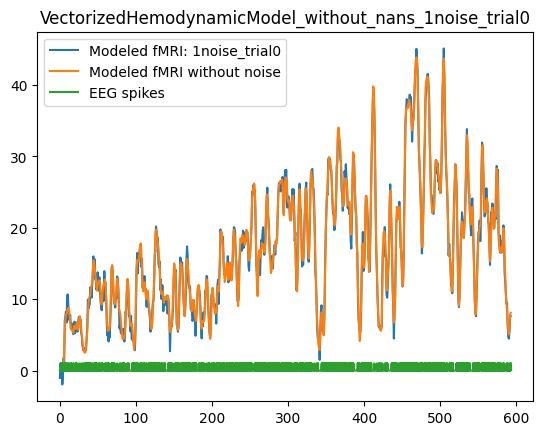

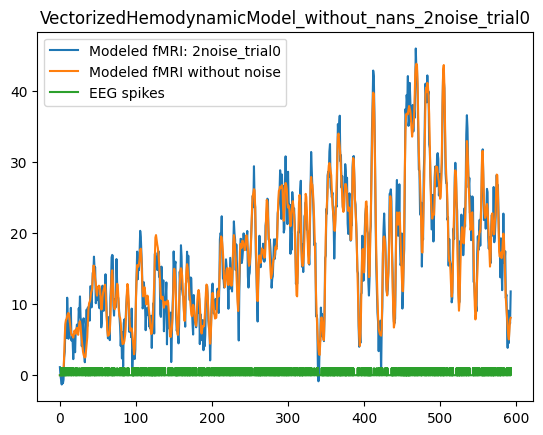

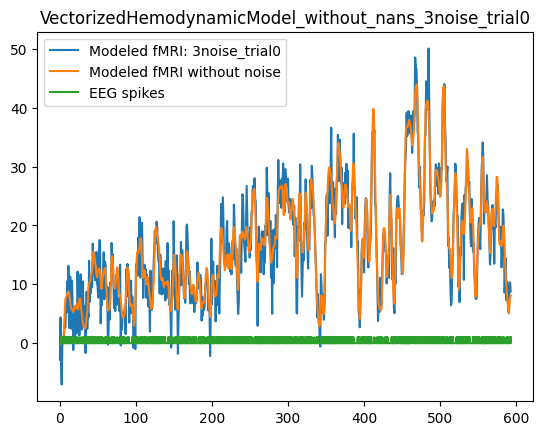

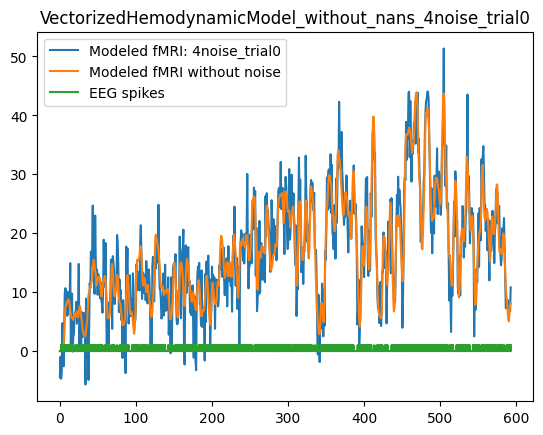

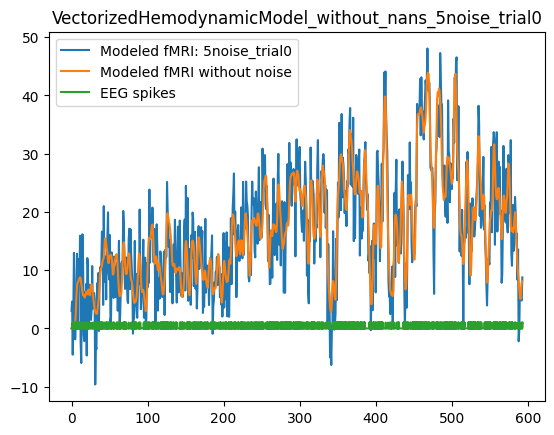

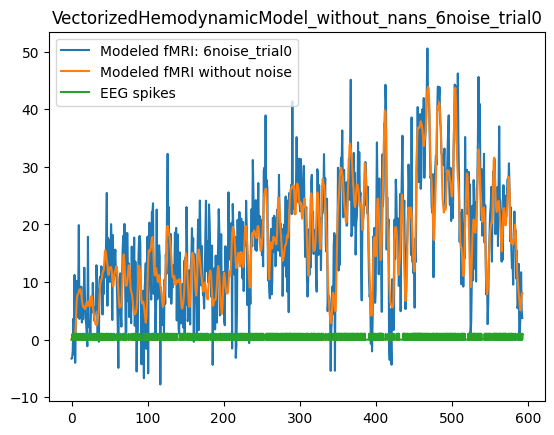

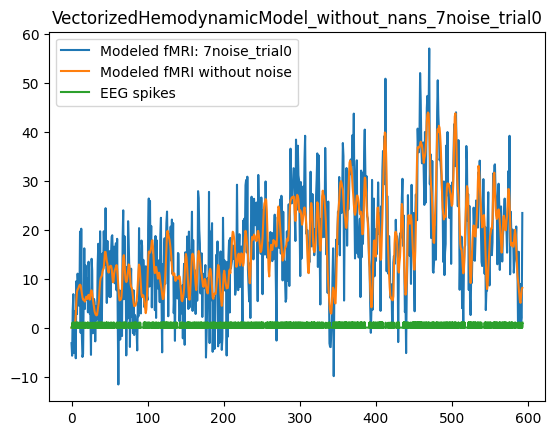

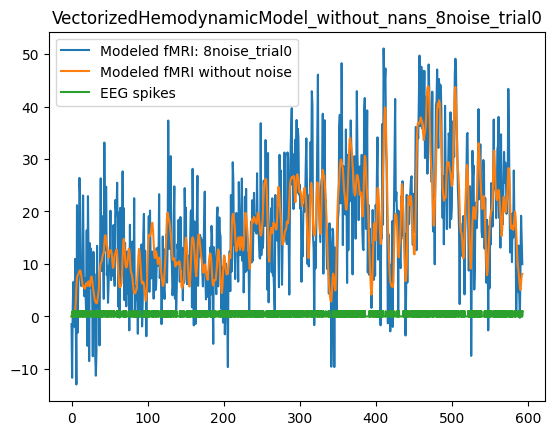

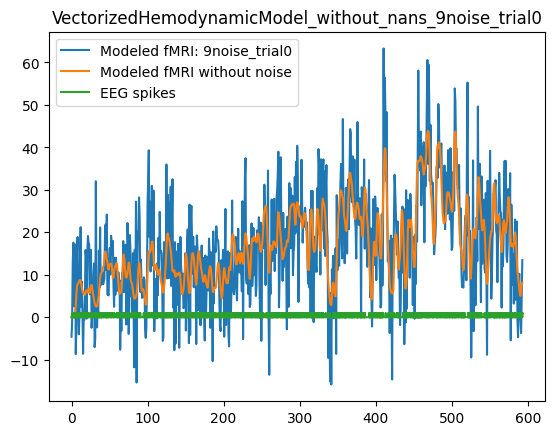

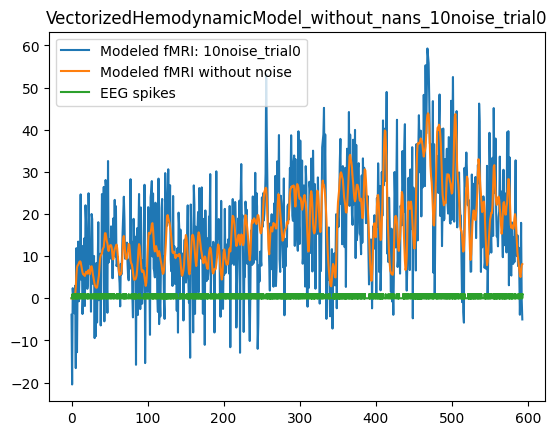

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2.25, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=2.25


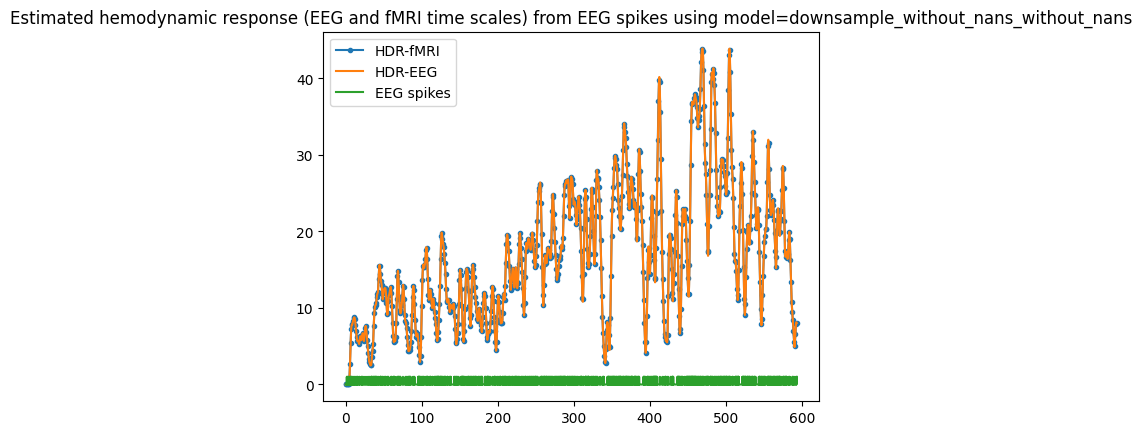

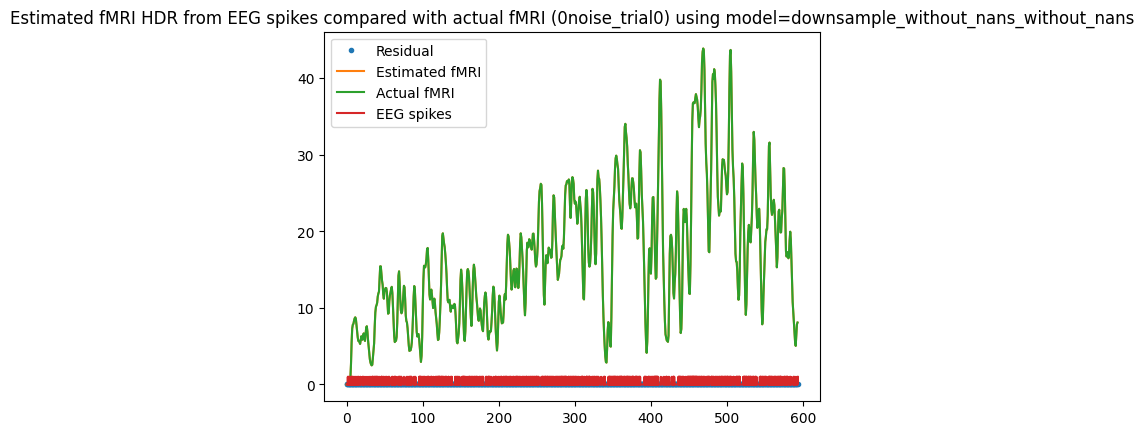

Residual Variance is 0.000000


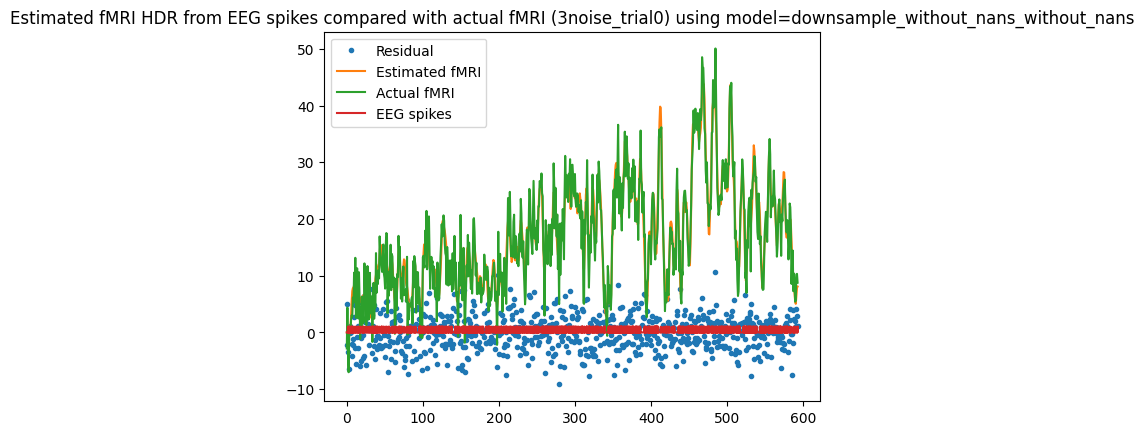

Residual Variance is 9.541698


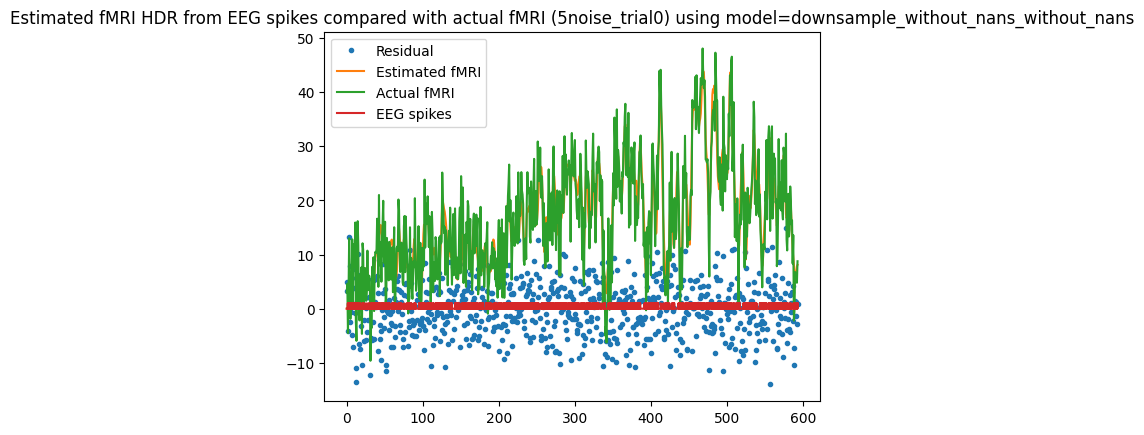

Residual Variance is 24.478430


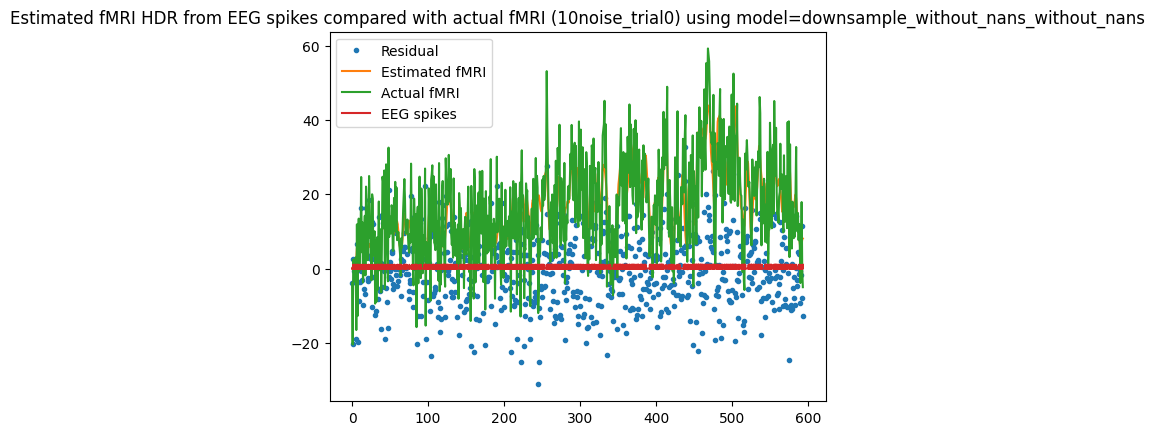

Residual Variance is 94.463876


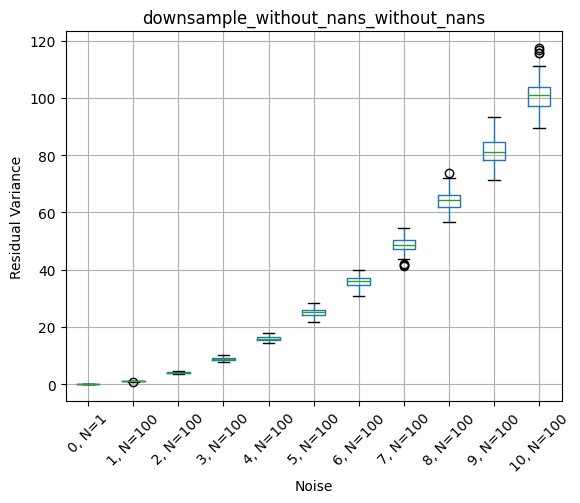

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=2.25


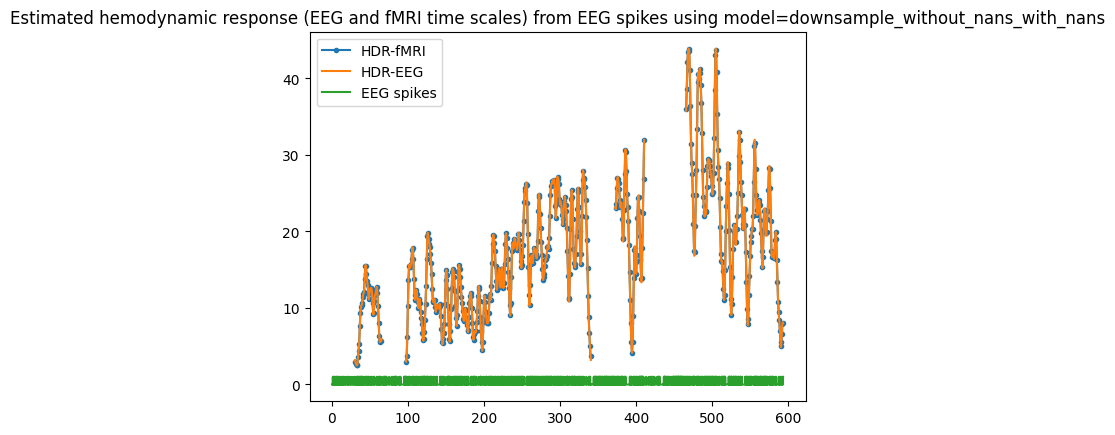

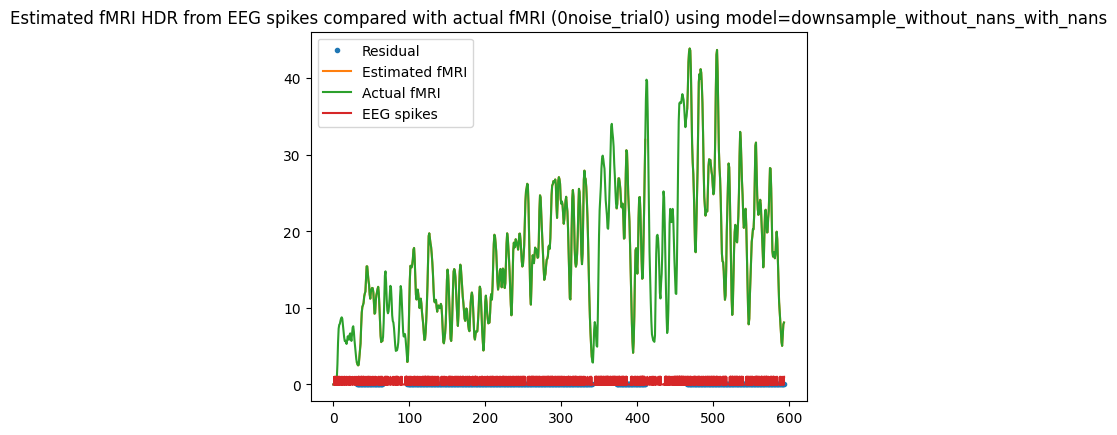

Residual Variance is 0.000000


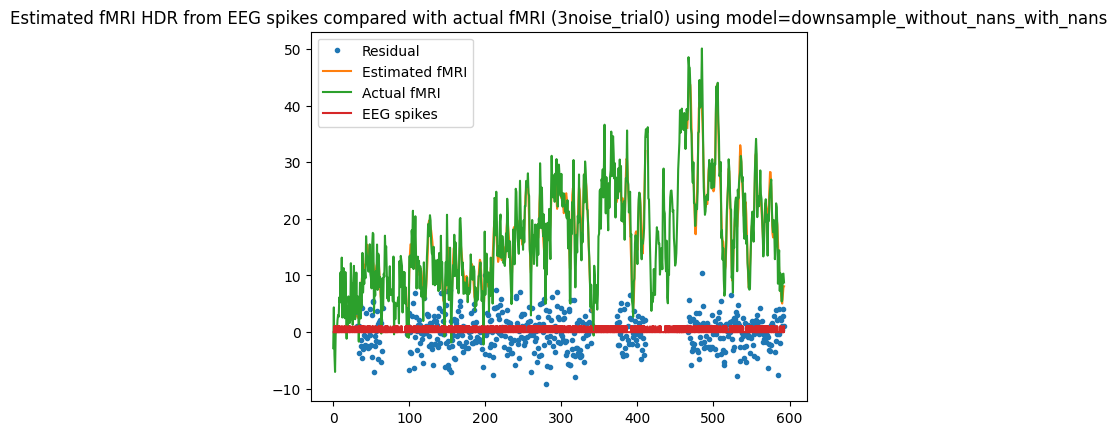

Residual Variance is 9.475653


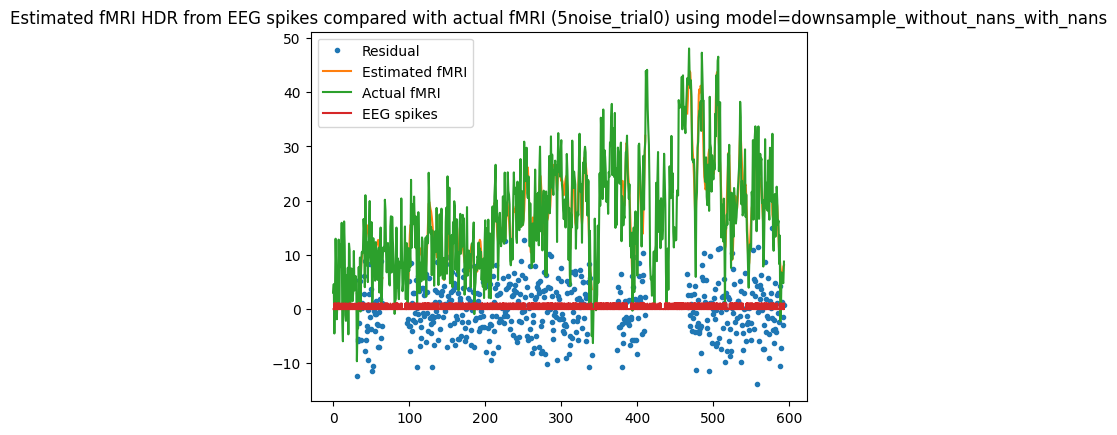

Residual Variance is 23.933498


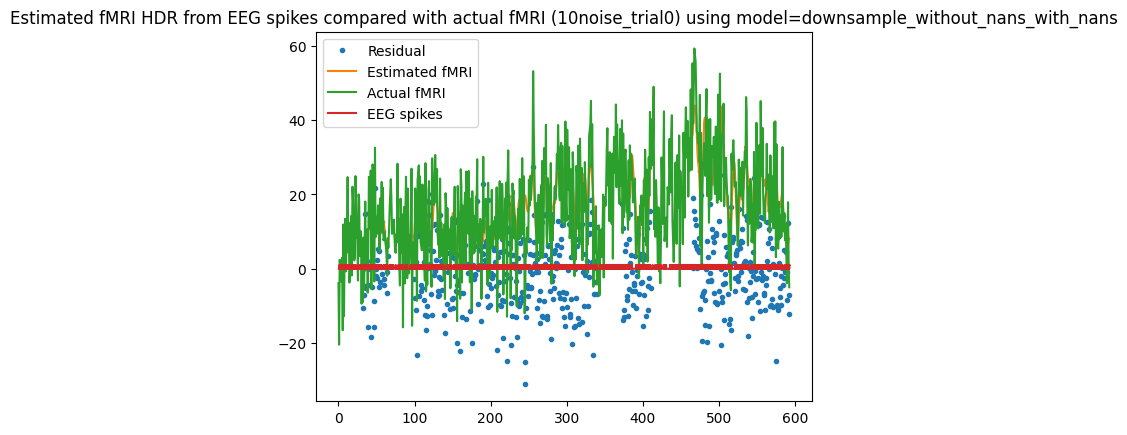

Residual Variance is 94.993411


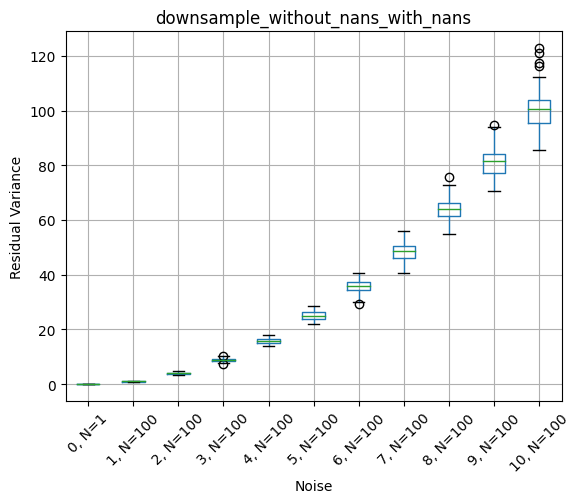

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   49.97519160981836   
1         downsample_without_nans_with_nans  45.187296438016126   
2      downsample_without_nans_without_nans   49.14658779970382   
3         downsample_without_nans_with_nans  44.493069224994116   
4      downsample_without_nans_without_nans  48.307123106674396   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  11.025375192366871   
18938  downsample_without_nans_without_nans   12.92346641448711   
18939     downsample_without_nans_with_nans   11.73423729450245   
18940  downsample_without_nans_without_nans  13.727018365014386   
18941     downsample_without_nans_with_nans  12.443390648120412   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       50.95872645381506  55.463878989131246  62.193155066726284   
1       46.60989433983617  48.792305093178086   59.00617416159395   
2      50.119888458143436   54.61323605929952   61.35121648580875   
3      45.902725740400825   48.10571818438558    58.2839449488826   
4       49.27060152335842   53.75103699146494   60.49751566966861   
...                   ...                 ...                 ...   
18937  11.735987486252165  15.503574618500457   20.70908783813953   
18938  13.728756548904641  18.149653578723985  21.954263029599076   
18939  12.439002335682492  16.204471021716827  21.461357003319755   
18940  14.526200750204131  18.985836940108467  22.760122827357343   
18941  13.143045720634893  16.905040397435695   22.21490574202939   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       65.88863311519079   75.44122316929956  ...  51.364456575042226   
1      61.309837174666825   69.10958516500982  ...   46.31028218228485   
2       65.05809033186671   74.61267794119314  ...    50.5371832751572   
3      60.594380066760976    68.4247327475135  ...  45.622057055625035   
4       64.21714938162317   73.77353411649042  ...   49.69881364220249   
...                   ...                 ...  ...                 ...   
18937  26.379033543314982   34.66088271711361  ...  11.881695925122218   
18938  27.871829535640128  37.596042106652554  ...   13.89627821712755   
18939  27.093173012101488   35.37554656716753  ...  12.589864192539627   
18940  28.658208753002686   38.43519569158074  ...   14.70372844915611   
18941   27.80915500929874   36.09253352934825  ...  13.298980523444333   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      54.187754317842355   58.15441496061777   69.11373317445542   
1       49.50538613332665   51.97161408512455   63.06385063320527   
2       53.34729045042683    57.3120993139731   68.22067173898306   
3       48.79647456742095   51.29143720616931  62.320512645009615   
4        52.4955458289366   56.45884492980627   67.31442759486072   
...                   ...                 ...                 ...   
18937  15.278701974938171   20.26349660880857  27.696665081152656   
18938  17.206212172625314  22.333531077091926   31.35483145497709   
18939  16.001959774427796   20.95396879298101  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.883375524734288e-28; at
       delta   tau  alpha
11790   2.25  1.25   2.25


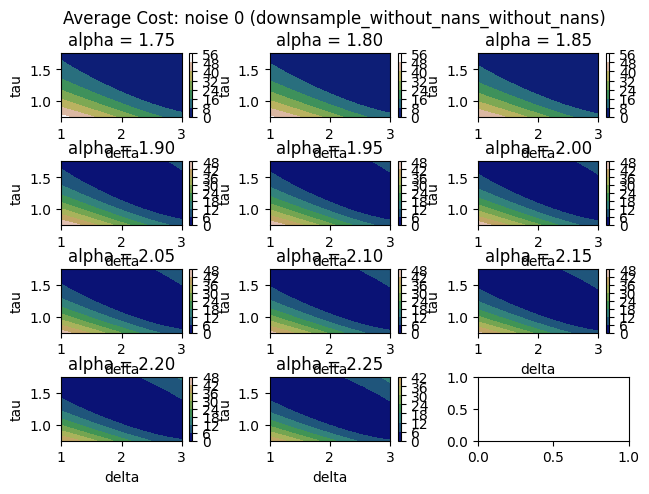

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              49.975192             
2                                              49.146588             
4                                              48.307123             
6                                              47.457336             
8                                              46.597794             
...                                                  ...             
18932                                          10.539958             
18934                                          11.328126             
18936                                          12.123252             
18938                                          12.923466             
18940                                          13.727018             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.25


delta   tau  alpha
0   2.25  1.25   2.25

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.25


noise iteration          cost  delta   tau  alpha
0      0         0  2.883376e-28   2.25  1.25   2.25
1      0         0  3.692824e-03   2.30  1.30   2.10
2      0         0  9.746995e-03   2.40  1.35   1.95

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration          cost  delta   tau  alpha
0      0         0  2.883376e-28   2.25  1.25   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.758731865168053e-28; at
       delta   tau  alpha
11791   2.25  1.25   2.25


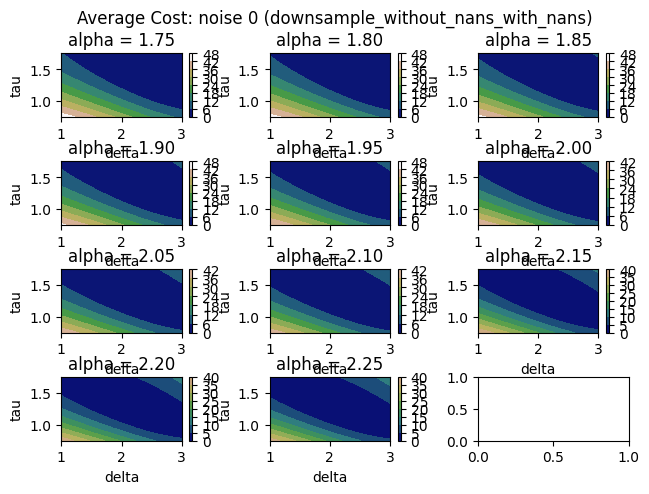

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              45.187296          
3                                              44.493069          
5                                              43.786851          
7                                              43.069037          
9                                              42.340061          
...                                                  ...          
18933                                           9.615182          
18935                                          10.318437          
18937                                          11.025375          
18939                                          11.734237          
18941                                          12.443391          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.25


delta   tau  alpha
0   2.25  1.25   2.25

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2.25


noise iteration          cost  delta   tau  alpha
0      0         0  1.758732e-28   2.25  1.25   2.25
1      0         0  3.606682e-03   2.30  1.30   2.10
2      0         0  9.107851e-03   2.40  1.35   1.95

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration          cost  delta   tau  alpha
0      0         0  1.758732e-28   2.25  1.25   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0016667754081596; at
       delta   tau  alpha
11790   2.25  1.25   2.25


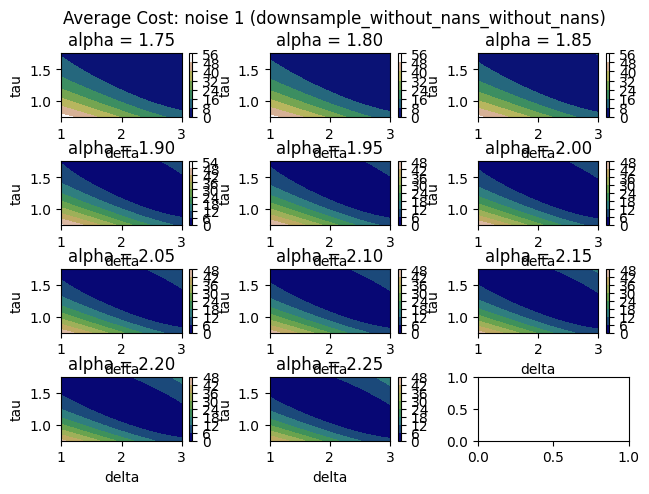

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.038785745807903; at
       delta   tau  alpha
11790   2.25  1.25   2.25


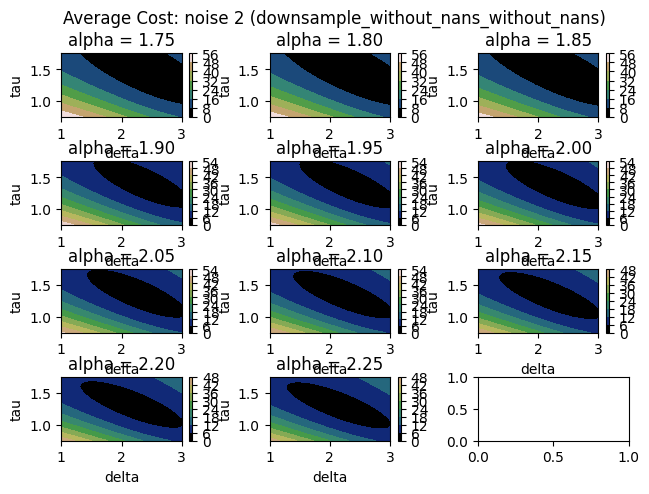

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.943378036732916; at
       delta   tau  alpha
11790   2.25  1.25   2.25


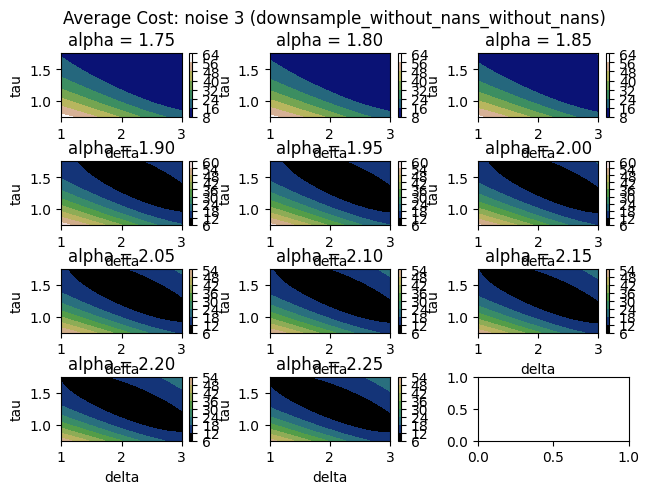

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.819205873649334; at
       delta   tau  alpha
11790   2.25  1.25   2.25


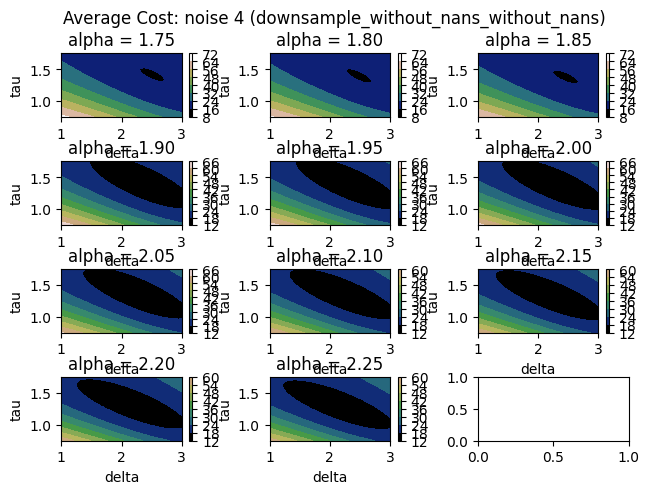

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.04184358564174; at
       delta   tau  alpha
11790   2.25  1.25   2.25


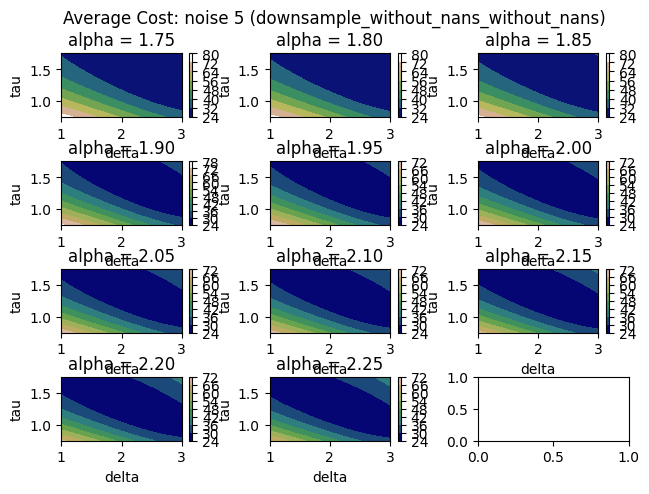

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.83600801991251; at
       delta   tau  alpha
11790   2.25  1.25   2.25


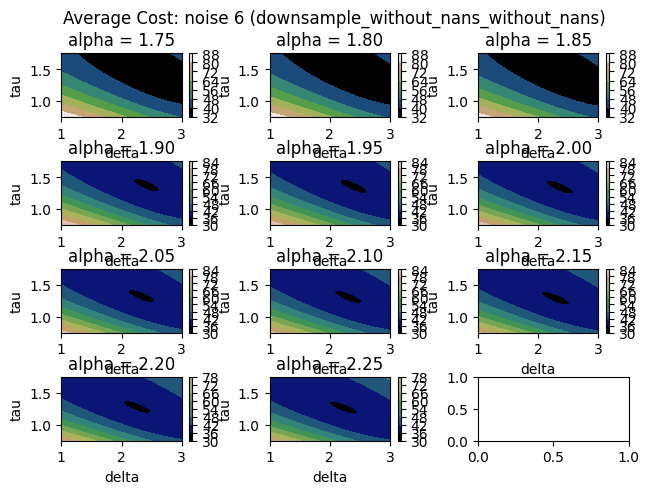

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.557104531595144; at
       delta   tau  alpha
11790   2.25  1.25   2.25


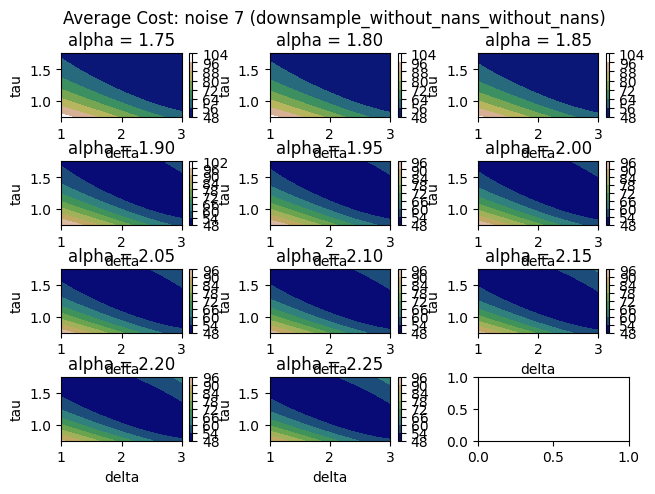

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.13643515465695; at
       delta   tau  alpha
11790   2.25  1.25   2.25


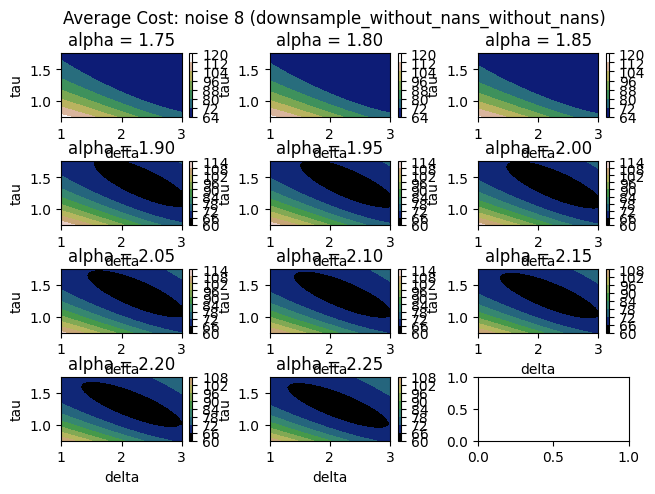

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.23129966870174; at
       delta   tau  alpha
13668   2.45  1.35    1.9


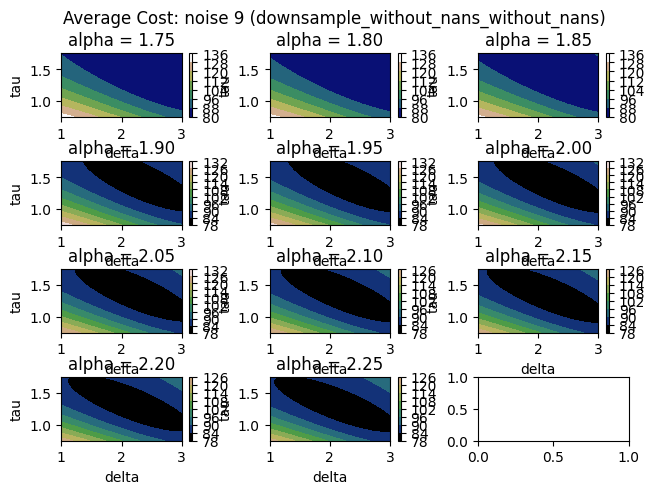

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.95130640095311; at
       delta   tau  alpha
11790   2.25  1.25   2.25


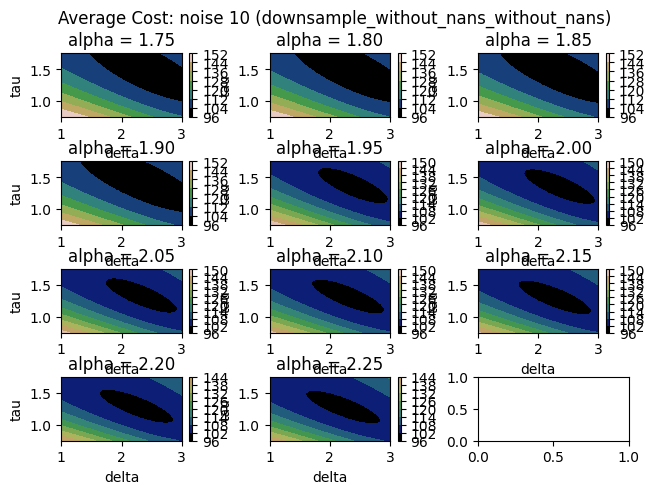

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

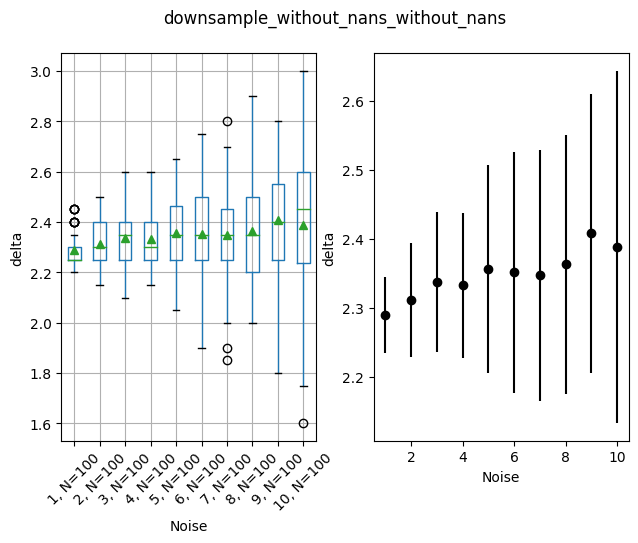

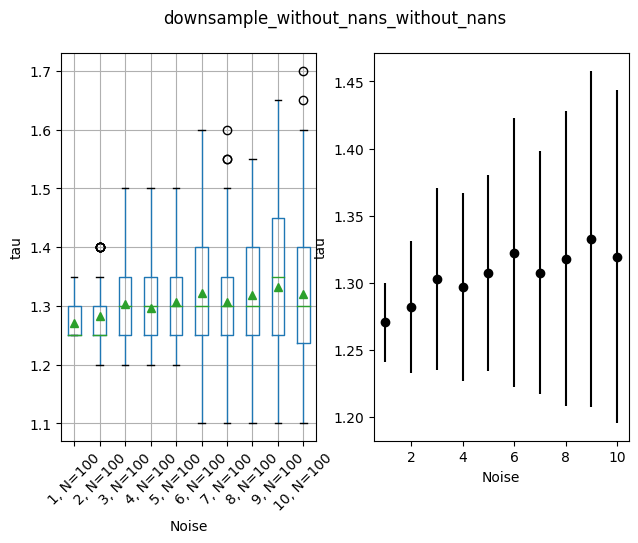

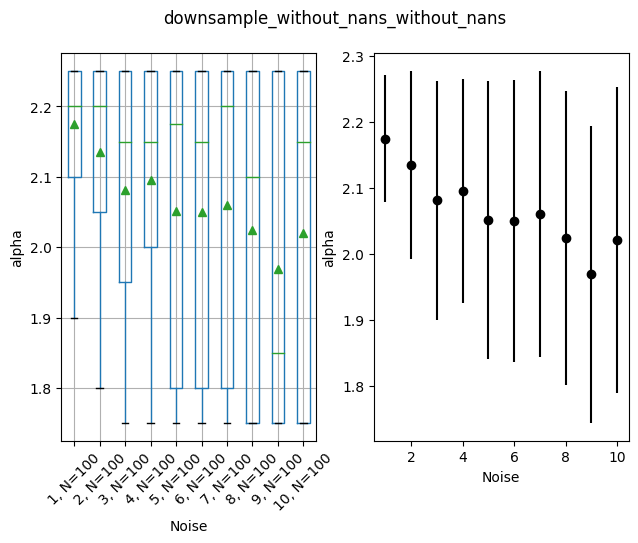

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9981440114862694; at
       delta   tau  alpha
11791   2.25  1.25   2.25


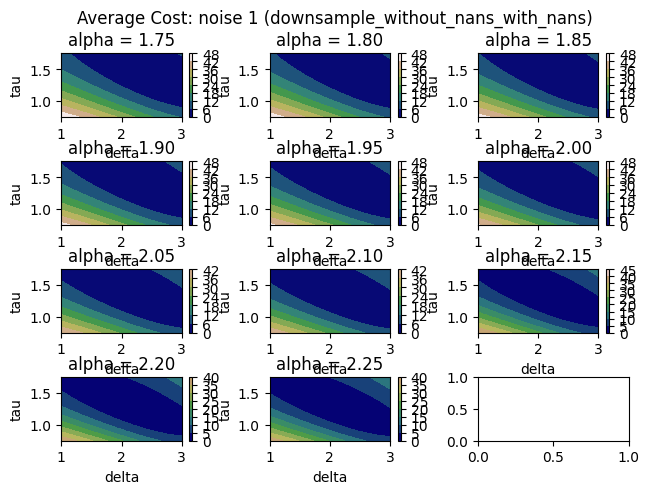

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.0257901021561615; at
       delta   tau  alpha
11791   2.25  1.25   2.25


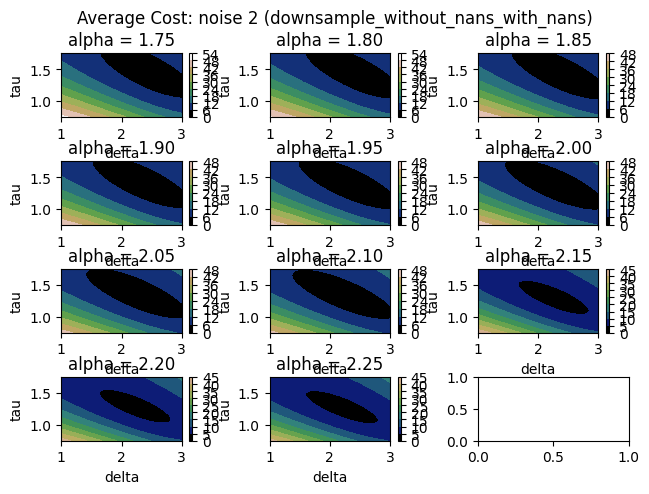

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.929734963793162; at
       delta   tau  alpha
11791   2.25  1.25   2.25


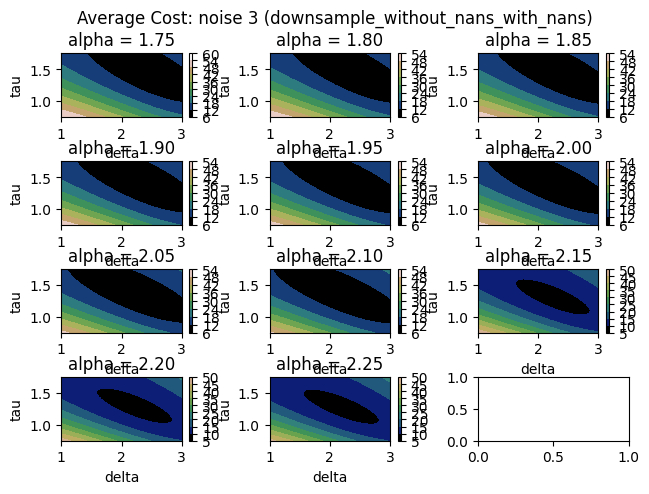

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.83178291383083; at
       delta   tau  alpha
11791   2.25  1.25   2.25


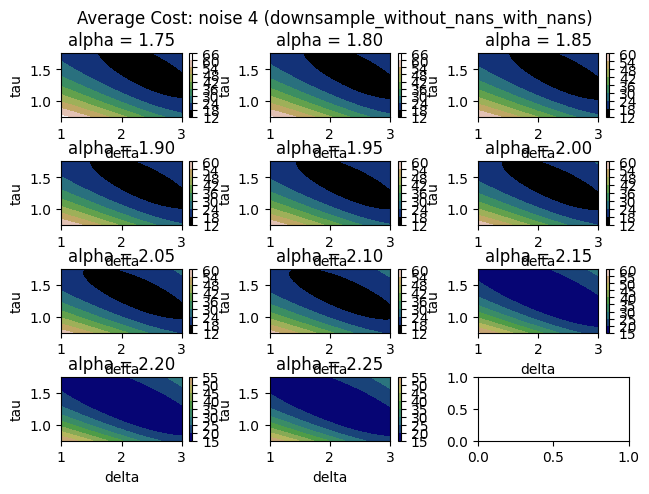

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.01063642209293; at
       delta   tau  alpha
12251    2.3  1.25    2.2


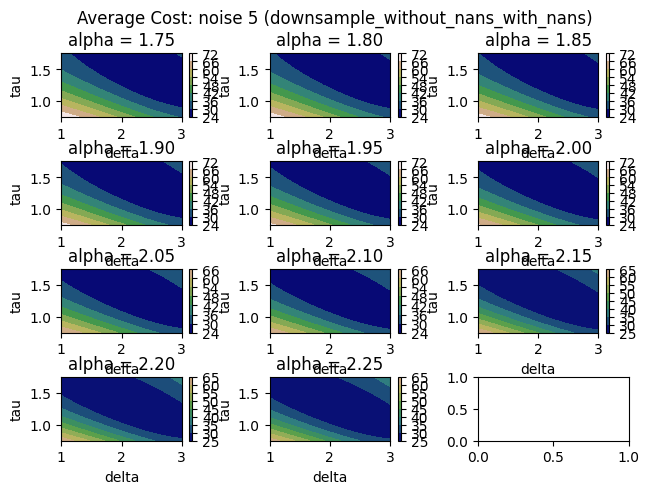

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.786782971133604; at
       delta  tau  alpha
12271    2.3  1.3   2.15


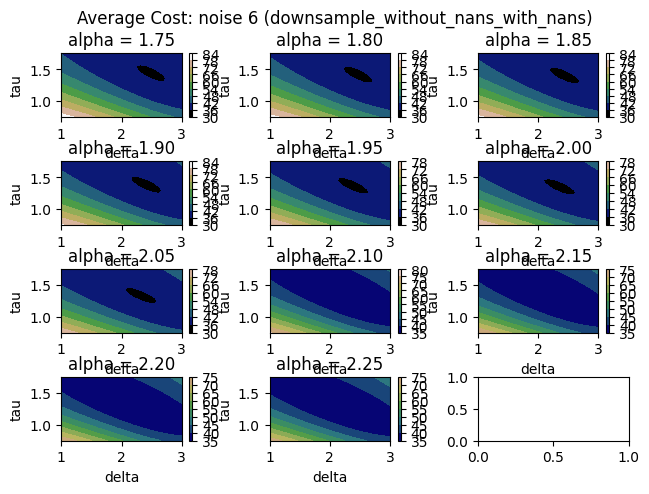

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.5155639736425; at
       delta   tau  alpha
11791   2.25  1.25   2.25


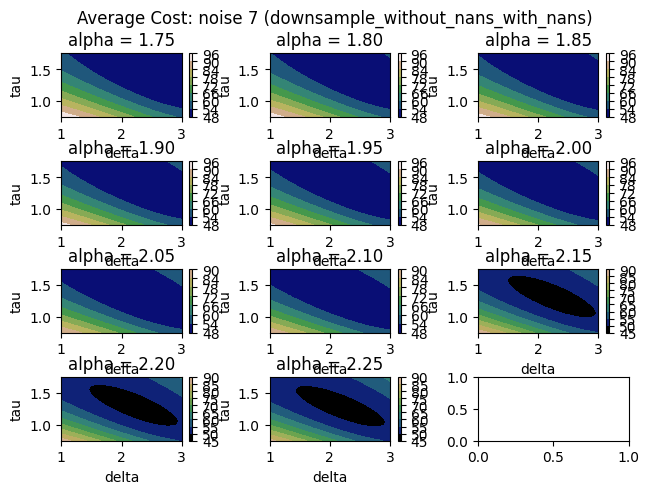

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.964197556532646; at
       delta  tau  alpha
12269    2.3  1.3    2.1


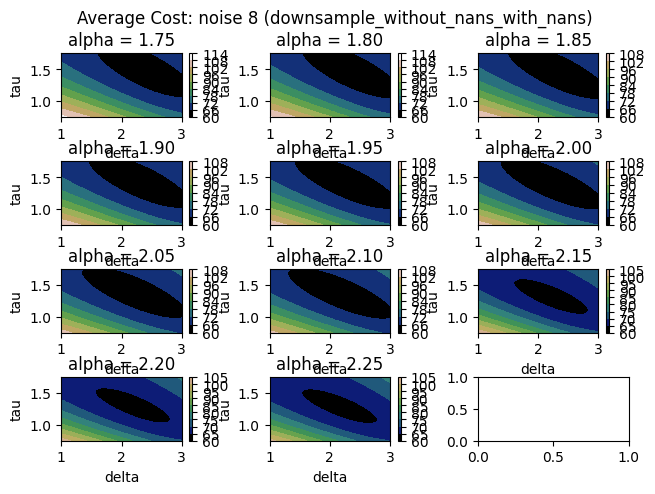

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.19898852842203; at
       delta  tau  alpha
12729   2.35  1.3   2.05


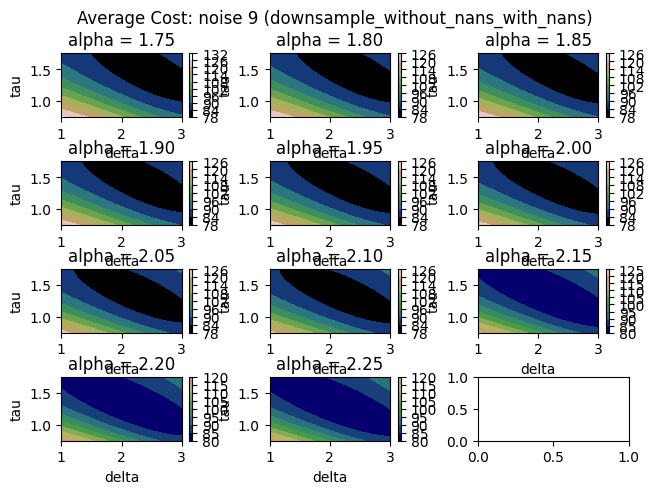

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.59576857761742; at
       delta   tau  alpha
11791   2.25  1.25   2.25


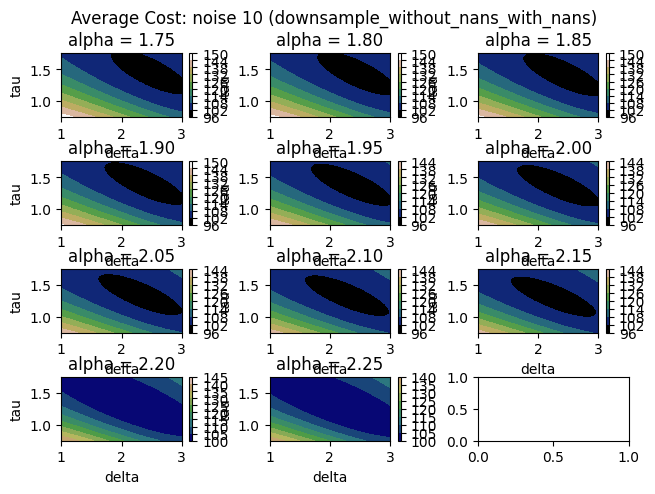

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


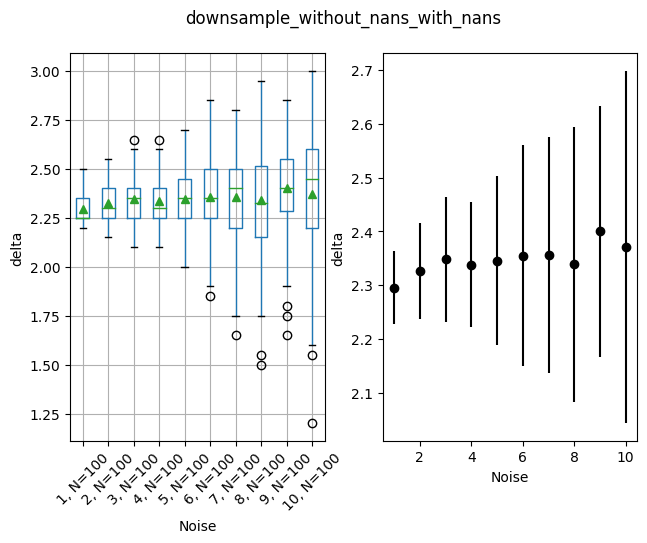

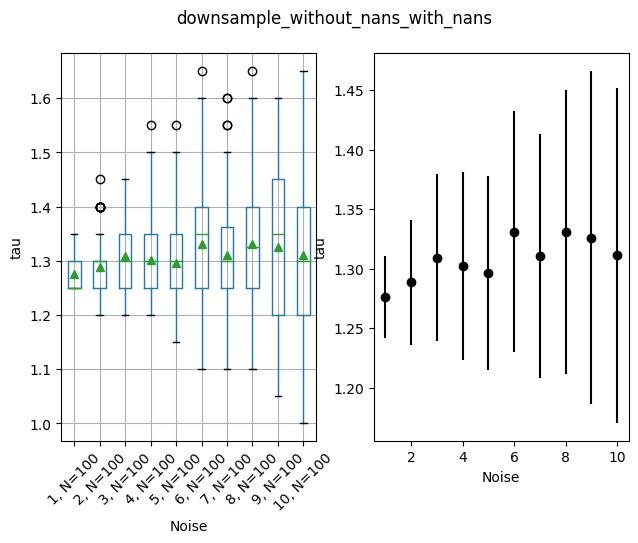

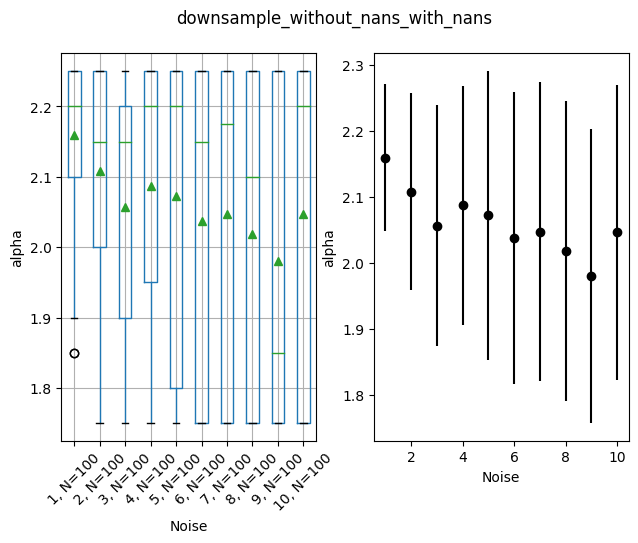

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        54    0.991646   2.200000000000001  1.2500000000000004   
1         1        69    1.011787   2.200000000000001  1.3000000000000005   
2         1         1    0.954183   2.250000000000001  1.2500000000000004   
3         1         2    1.064461   2.250000000000001  1.2500000000000004   
4         1         3    0.975041   2.250000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2668     10        48  101.297930  2.8500000000000014  1.1500000000000004   
2669     10        68  101.464304  2.8500000000000014  1.2000000000000004   
2670     10        68  101.489729  2.9000000000000017  1.2500000000000004   
2671     10        61  100.508844   2.950000000000002  1.3000000000000005   
2672     10        17   97.034645  3.0000000000000018  1.2000000000000004   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2668                1.75  
2669  1.9000000000000001  
2670                1.75  
2671                1.85  
2672                1.75  

[2673 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.46  0.593228  2.0  3.0  4.0  4.0  4.0
2                      100.0  3.26  0.746980  1.0  3.0  3.0  4.0  5.0
3                      100.0  3.07  0.966667  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.90  1.058873  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.56  1.131014  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.44  1.166190  1.0  1.0  3.0  3.0  5.0
7                      100.0  2.41  1.120020  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.36  1.176538  1.0  1.0  2.0  3.0  5.0
9                      100.0  2.25  1.217507  1.0  1.0  2.0  3.0  5.0
10                     100.0  2.02  1.205878  1.0  1.0  2.0  3.0  6.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost               delta                 tau alpha
2672     10        17  97.034645  3.0000000000000018  1.2000000000000004  1.75

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
316       1        29    0.955976  2.5000000000000013  1.4000000000000006   
317       1        39    0.925198  2.5000000000000013  1.4000000000000006   
318       1        41    1.083431  2.5000000000000013  1.4000000000000006   
319       1        56    0.996175  2.5000000000000013  1.4000000000000006   
320       1        57    1.027140  2.5000000000000013  1.4000000000000006   
...     ...       ...         ...                 ...                 ...   
2663     10        20  109.111643  2.7500000000000018  1.2000000000000004   
2667     10        18  110.228403  2.8000000000000016  1.4000000000000006   
2668     10        48  101.297930  2.8500000000000014  1.1500000000000004   
2670     10        68  101.489729  2.9000000000000017  1.2500000000000004   
2672     10        17   97.034645  3.0000000000000018  1.2000000000000004   

     alpha  
316   1.75  
317   1.75  
318   1.75  
319   1.75  
320   1.75  
...    ...  
2663  1.75  
2667  1.75  
2668  1.75  
2670  1.75  
2672  1.75  

[308 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        18      2  2.5500000000000016   10    18      1  1.4000000000000006   
10       38     16  2.6000000000000014    9    38     12  1.4000000000000006   
2        19      4  2.5000000000000013    9    19      2  1.4000000000000006   
3        25      6  2.5000000000000013    9    25      4  1.4500000000000006   
4        23      5  2.5000000000000013    9    23      4  1.4000000000000006   
5        30      6  2.5500000000000016    9    30      5  1.4000000000000006   
6        31     12  2.5000000000000013    7    31      6  1.4000000000000006   
7        32     11  2.4000000000000012    6    32      8  1.3500000000000005   
8        42     15  2.5000000000000013    6    42      7  1.4000000000000006   
9        50     15  2.5000000000000013    9    50      9  1.5000000000000007   

            
      freq  
noise       
1       18  
10       8  
2       16  
3       11  
4       11  
5       11  
6       13  
7       10  
8       11  
9       13

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        54    0.991646   2.200000000000001  1.2500000000000004   
2         1         1    0.954183   2.250000000000001  1.2500000000000004   
3         1         2    1.064461   2.250000000000001  1.2500000000000004   
4         1         3    0.975041   2.250000000000001  1.2500000000000004   
5         1         5    1.020891   2.250000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2626     10        35   95.305663  2.6000000000000014  1.2000000000000004   
2644     10        67   95.686637  2.6500000000000012  1.1000000000000003   
2645     10        71  101.486820  2.6500000000000012  1.1000000000000003   
2654     10        68  101.416162  2.7000000000000015  1.1000000000000003   
2657     10        61  100.480052  2.7000000000000015  1.2000000000000004   

                   alpha  
0     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
...                  ...  
2626  2.2500000000000004  
2644  2.2500000000000004  
2645  2.2500000000000004  
2654  2.2500000000000004  
2657  2.2500000000000004  

[546 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        69      3   2.250000000000001   66    69      1  1.2500000000000004   
10       53     21   2.300000000000001    7    53      9  1.2000000000000004   
2        58      6   2.250000000000001   38    58      3  1.2500000000000004   
3        59      7   2.250000000000001   16    59      3  1.2500000000000004   
4        45      8   2.250000000000001   10    45      3  1.2000000000000004   
5        53     10   2.250000000000001   13    53      5  1.2500000000000004   
6        51     16   2.300000000000001   10    51      7  1.2500000000000004   
7        56     11  2.1500000000000012   12    56      7  1.2500000000000004   
8        55     15  2.1500000000000012    8    55      8  1.2500000000000004   
9        47     17   2.200000000000001    9    47      8  1.2500000000000004   

            
      freq  
noise       
1       69  
10      12  
2       50  
3       40  
4       17  
5       24  
6       17  
7       18  
8       17  
9       13

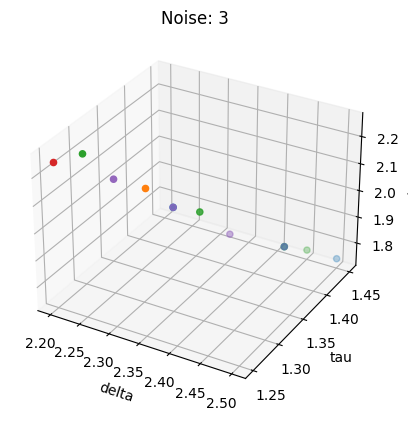

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

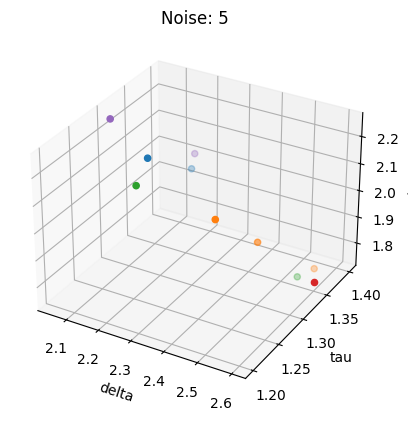

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

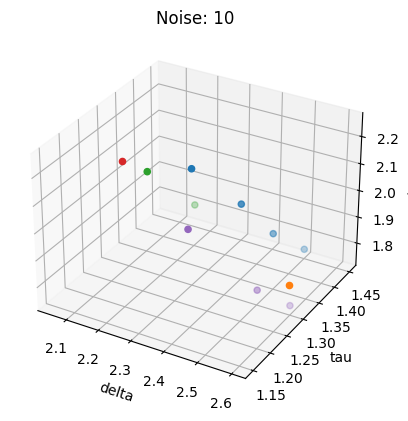

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        13    0.928987   2.200000000000001  1.2500000000000004   
1         1        27    1.055702   2.200000000000001  1.2500000000000004   
2         1        54    1.007205   2.200000000000001  1.2500000000000004   
3         1        63    1.002136   2.200000000000001  1.2500000000000004   
4         1        86    1.024199   2.200000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2568     10        68  102.776632  2.9000000000000017  1.1500000000000004   
2569     10        35   91.521757  2.9000000000000017  1.1500000000000004   
2570     10        35   91.543391   2.950000000000002  1.2000000000000004   
2571     10        17   93.160691   2.950000000000002  1.2500000000000004   
2572     10        20  106.117310  3.0000000000000018  1.1500000000000004   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2568                 2.0  
2569  2.1500000000000004  
2570                 2.0  
2571                1.75  
2572                1.75  

[2573 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.38  0.632136  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.24  0.877554  1.0  3.0  3.0  4.0  4.0
3                      100.0  3.05  1.067187  1.0  2.0  3.0  4.0  4.0
4                      100.0  2.84  1.098392  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.36  1.123846  1.0  1.0  2.0  3.0  5.0
6                      100.0  2.34  1.147857  1.0  1.0  2.0  3.0  4.0
7                      100.0  2.21  1.121822  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.20  1.206045  1.0  1.0  2.0  3.0  5.0
9                      100.0  2.12  1.191553  1.0  1.0  2.0  3.0  5.0
10                     100.0  1.99  1.087068  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost               delta                 tau alpha
2572     10        20  106.11731  3.0000000000000018  1.1500000000000004  1.75

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
307       1         0    1.026232   2.450000000000001  1.4500000000000006   
308       1        51    1.024109   2.450000000000001  1.4500000000000006   
313       1        12    0.871383  2.5000000000000013  1.4000000000000006   
314       1        22    0.944531  2.5000000000000013  1.4000000000000006   
315       1        39    0.919213  2.5000000000000013  1.4000000000000006   
...     ...       ...         ...                 ...                 ...   
2553     10        62  107.174784  2.7500000000000018  1.2000000000000004   
2561     10        98   96.526223  2.8000000000000016  1.3500000000000005   
2562     10        18  111.336603  2.8000000000000016  1.4000000000000006   
2571     10        17   93.160691   2.950000000000002  1.2500000000000004   
2572     10        20  106.117310  3.0000000000000018  1.1500000000000004   

     alpha  
307   1.75  
308   1.75  
313   1.75  
314   1.75  
315   1.75  
...    ...  
2553  1.75  
2561  1.75  
2562  1.75  
2571  1.75  
2572  1.75  

[315 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        16      3  2.5000000000000013    7    16      2  1.4000000000000006   
10       37     16  2.6000000000000014    7    37     11  1.5000000000000007   
2        23      3  2.5000000000000013   11    23      2  1.4000000000000006   
3        24      7  2.5000000000000013    6    24      3  1.4000000000000006   
4        23      7  2.5000000000000013    6    23      6  1.4500000000000006   
5        33     10  2.5000000000000013    7    33      6  1.4000000000000006   
6        38     12  2.5500000000000016    9    38      8  1.4000000000000006   
7        35     12  2.4000000000000012    6    35      8  1.4000000000000006   
8        42     17  2.6500000000000012    6    42     10  1.3500000000000005   
9        44     15  2.4000000000000012    7    44     10  1.4500000000000006   

            
      freq  
noise       
1       14  
10       6  
2       17  
3       11  
4        9  
5       12  
6       10  
7        8  
8       10  
9        9

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        13    0.928987   2.200000000000001  1.2500000000000004   
1         1        27    1.055702   2.200000000000001  1.2500000000000004   
2         1        54    1.007205   2.200000000000001  1.2500000000000004   
3         1        63    1.002136   2.200000000000001  1.2500000000000004   
4         1        86    1.024199   2.200000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2528     10        71  100.515352  2.6500000000000012  1.1000000000000003   
2531     10         6  100.320697  2.6500000000000012  1.1500000000000004   
2544     10        87   99.714452  2.7000000000000015  1.1500000000000004   
2558     10        67   94.484740  2.8000000000000016  1.1000000000000003   
2567     10        35   91.519047  2.9000000000000017  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2528  2.2500000000000004  
2531  2.2500000000000004  
2544  2.2500000000000004  
2558  2.2500000000000004  
2567  2.2500000000000004  

[538 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        60      3   2.250000000000001   50    60      1  1.2500000000000004   
10       63     27   2.250000000000001    7    63     12  1.3000000000000005   
2        48      5   2.250000000000001   23    48      2  1.2500000000000004   
3        49      8   2.200000000000001   14    49      3  1.2500000000000004   
4        52      8   2.250000000000001   16    52      4  1.2500000000000004   
5        59     12   2.250000000000001   11    59      5  1.2500000000000004   
6        55     16   2.250000000000001    7    55      7  1.2500000000000004   
7        51     14   2.300000000000001    7    51      8  1.2500000000000004   
8        55     20   2.100000000000001    7    55     10  1.2500000000000004   
9        46     16  2.5500000000000016    6    46      9  1.2000000000000004   

            
      freq  
noise       
1       60  
10      14  
2       39  
3       28  
4       26  
5       20  
6       19  
7       17  
8       11  
9       10

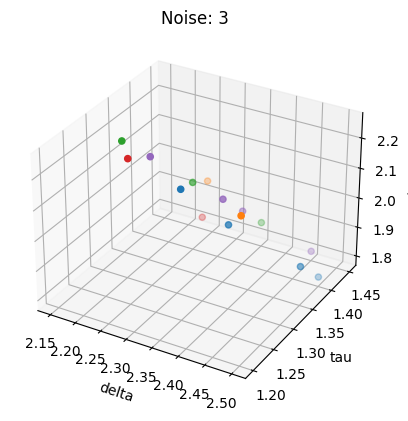

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

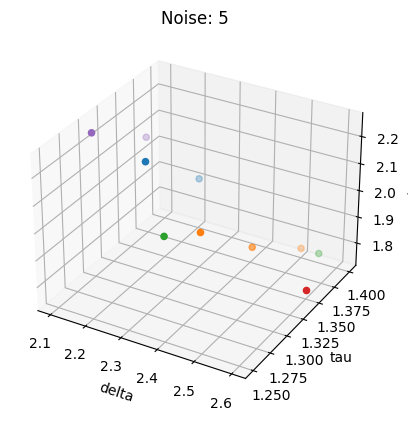

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

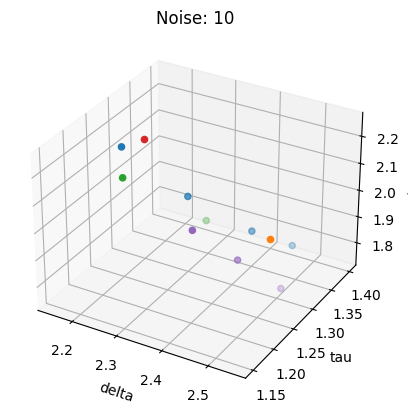

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()